In [1]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [1]:
!pip install -q rouge-score

In [2]:
import os
import re
import pprint
import random
import pickle
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, TimeDistributed, Concatenate, Dense, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# from tensorflow.keras.layers import Attention
from keras.utils import plot_model
# from rouge import Rouge
from rouge_score import rouge_scorer


seed = random.seed(42)

In [3]:
drive.mount('/content/drive')
! cd drive
os.chdir("/content/drive/MyDrive/Data 266 Project/LSTM")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 attention.py			   df_clean.csv   model_plot_attn.png   x_tokenizer.pickle
'Copy of Data Preparation.ipynb'   df.csv	  model_plot.png        y_tokenizer.pickle
'Copy of Model.ipynb'		   lstm-model3	 'Model Weights'
'Data Preparation.ipynb'	   Model.ipynb	  __pycache__


In [4]:
PATH = os.getcwd()
PATH
from attention import AttentionLayer

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Check if a GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4718141568629381105
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14410383360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3216105743630264328
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Training-Validation Split

In [6]:
df = pd.read_csv("df_clean.csv")
X = np.array(df['content'])
Y = np.array(df['summary'])

In [7]:
x_train,x_valid,y_train,y_valid=train_test_split(X,Y,test_size=0.15,random_state=seed,shuffle=True)
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(30600,)
(5400,)
(30600,)
(5400,)


# Word Embeddings

In [8]:
def word_freq_dict(df, column_name):
    """
    Creates a dictionary of word frequencies from a specified column in a pandas DataFrame.
    """
    if column_name not in df.columns:
        raise ValueError(f"Column {column_name} not found in DataFrame")

    word_dict = {}
    content = df[column_name]

    for row in content:
        for word in row.split(" "):
            if word not in word_dict:
                word_dict[word] = 1
            else:
                word_dict[word] += 1

    return word_dict

In [9]:
x_word_dict = word_freq_dict(df, 'content')
y_word_dict = word_freq_dict(df, 'summary')
print(len(x_word_dict))
print(len(y_word_dict))

51918
19817


In [10]:
MAX_CONTENT_LEN = 200
MAX_SUMMARY_LEN = 35

In [11]:
def tokenization_padding(train, valid, word_dict,max_len):
    """
    Prepares tokenization and padding for the text and summary data.

    """
    # Prepare a tokenizer for text data
    tokenizer = Tokenizer(num_words=len(word_dict), split=" ")
    tokenizer.fit_on_texts(list(train))

    train_seq = tokenizer.texts_to_sequences(train)
    valid_seq = tokenizer.texts_to_sequences(valid)

    train = pad_sequences(train_seq, maxlen=max_len, padding='post')
    valid = pad_sequences(valid_seq, maxlen=max_len, padding='post')
    voc_size = tokenizer.num_words + 1

    return (train, valid, tokenizer, voc_size)


In [12]:
# tokenizer for content
(x_train, x_valid, x_tokenizer, x_vocab_size) = tokenization_padding(x_train, x_valid, x_word_dict, MAX_CONTENT_LEN)
(y_train, y_valid, y_tokenizer, y_vocab_size) = tokenization_padding(y_train, y_valid, y_word_dict, MAX_SUMMARY_LEN)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)


(30600, 200)
(30600, 35)
(5400, 200)
(5400, 35)


In [14]:
print(x_vocab_size)
print(y_vocab_size)

51919
19818


In [15]:
y_tokenizer.word_counts['sostok'], len(y_train)

(30600, 30600)

In [ ]:
with open('x_tokenizer.pickle', 'wb') as handle:
  pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('y_tokenizer.pickle', 'wb') as handle:
  pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('x_tokenizer.pickle', 'rb') as file:
    x_tokenizer_test = pickle.load(file)


In [ ]:
with open('y_tokenizer.pickle', 'rb') as file:
    y_tokenizer_test = pickle.load(file)

In [ ]:
new_texts = ["this is an example"]
sequences = x_tokenizer_test.texts_to_sequences(new_texts)
print(sequences)

In [ ]:
sequences2 = y_tokenizer_test.texts_to_sequences(new_texts)
print(sequences2)

**Encoder**

 The code below defines an encoder for a seq2seq model with a bidirectional LSTM.
 The encoder processes the input sequence, creates an embedding, and passes it through the LSTM to obtain a rich representation of the input. The final states of the LSTM (after processing the entire input sequence) are used to initialize the decoder, which will generate the output sequence in the next steps of the model.

**Decoder**

 The decoder receives a sequence (i.e. a partial summary), processes it through an embedding layer and an LSTM layer, and then uses a dense layer with softmax activation to predict the next word in the sequence. The LSTM's initial state is set to the encoder's final state, enabling the decoder to use the context captured by the encoder.

In [16]:
LATENT_DIM = 256
EMBEDDING_DIM = 128

In [ ]:
# from keras import backend as K
# K.clear_session()


# # Builds the encoder part of the seq2seq model.

# encoder_inputs = Input(shape=(MAX_CONTENT_LEN,))

# # Embedding layer
# encoder_embedding = Embedding(x_vocab_size,
#                               EMBEDDING_DIM,
#                               trainable=True)(encoder_inputs)

# # encoder lstm 1
# encoder_lstm1 = LSTM(LATENT_DIM,
#                       return_sequences=True,
#                       return_state=True)
#                       # dropout = 0.4,
#                       # recurrent_dropout = 0.4)
# encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)


# # encoder lstm 2
# encoder_lstm2 = LSTM(LATENT_DIM,
#                       return_sequences=True,
#                       return_state=True)
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# # encoder lstm 3
# encoder_lstm3=LSTM(LATENT_DIM,
#                    return_state=True,
#                    return_sequences=True)

# # Outputs and encoder final states
# encoder_outputs, state_h, state_c=encoder_lstm3(encoder_output2)

# # Decoder

# decoder_inputs = Input(shape=(None,))

# # Embedding layer
# decoder_embedding_layer = Embedding(y_vocab_size,
#                                     EMBEDDING_DIM,
#                                     trainable=True)
# decoder_embedding = decoder_embedding_layer(decoder_inputs)

# # decoder LSTM
# decoder_lstm = LSTM(LATENT_DIM,
#                     return_sequences=True,
#                     return_state=True)
# decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_embedding,
#                                                                     initial_state=[state_h, state_c])


# # Attention layer
# attention_layer = AttentionLayer(name='attention_layer')
# # Attention layer takes encoder outputs and decoder outputs and returns context vector
# attention_output, attention_state = attention_layer([encoder_outputs, decoder_outputs])

# # Concat attention input and decoder LSTM output
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_output])


# # Dense layer with softmax activation
# decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
# decoder_outputs = decoder_dense(decoder_concat_input)


In [ ]:
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# model.summary()


In [ ]:
# plot_model(model, to_file='model_plot_attn.png', show_shapes=True, show_layer_names=True)

In [17]:
from keras import backend as K
K.clear_session()

encoder_inputs = Input(shape=(MAX_CONTENT_LEN,))

# Embedding layer
encoder_embedding = Embedding(x_vocab_size,
                              EMBEDDING_DIM,
                              trainable=True)(encoder_inputs)


encoder_lstm = Bidirectional(LSTM(LATENT_DIM,
                      return_sequences=True,
                      return_state=True))

encoder_outputs, fw_state_h, fw_state_c, bw_state_h, bw_state_c = encoder_lstm(encoder_embedding)

state_h = Concatenate()([fw_state_h, bw_state_h])
state_c = Concatenate()([fw_state_c, bw_state_c])
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))

#embedding layer
decoder_embedding_layer = Embedding(y_vocab_size, EMBEDDING_DIM,trainable=True)
decoder_embedding = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(LATENT_DIM*2, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_embedding,initial_state=encoder_states)

#dense layer
#soft max creates a prob vector that allows us to determine the final output
decoder_dense = Dense(y_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [18]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 200, 128)             6645632   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 200, 512),           788480    ['embedding[0][0]']           
 al)                          (None, 256),                                                    

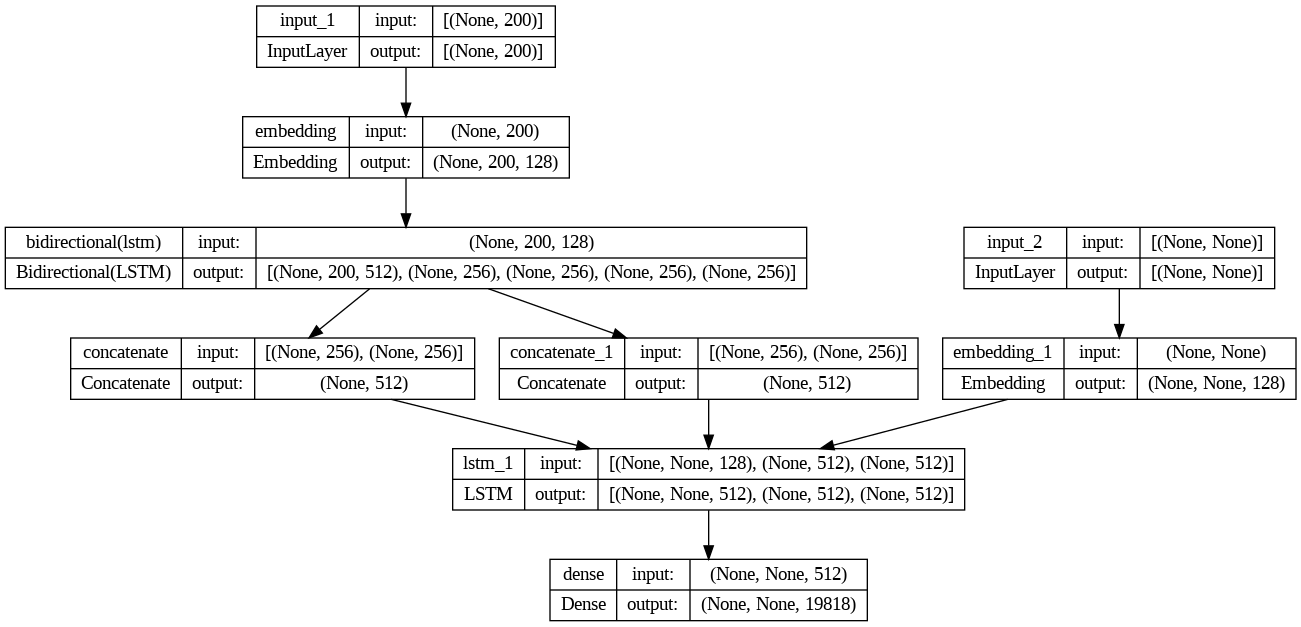

In [19]:
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [20]:
def create_callbacks(base_path='/model', project_name='lstm-model4'):
    # EarlyStopping callback
    es = EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=2,
        restore_best_weights=False
    )

    # ModelCheckpoint callback
    filename = "saved-model-{epoch:02d}.keras"
    filepath = os.path.join(base_path, project_name, filename)
    mc = ModelCheckpoint(
        filepath,
        monitor='val_loss',
        verbose=0,
        save_best_only=False,
        save_weights_only=False,
        mode='auto',
        save_freq='epoch'
    )

    return [es, mc]

callbacks = create_callbacks(PATH)

# model.fit(..., callbacks=callback

In [21]:
LEARNING_RATE=0.001
optimizer = RMSprop(learning_rate=LEARNING_RATE, rho=0.9)

In [22]:
model.compile(optimizer= optimizer, loss='sparse_categorical_crossentropy')

In [23]:
BATCH_SIZE = 100
EPOCHS = 50

In [ ]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [24]:
y_train_3d = y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:]
y_valid_3d = y_valid.reshape(y_valid.shape[0],y_valid.shape[1], 1)[:,1:]

In [25]:
history = model.fit([x_train, y_train[:,:-1]],
                    y_train_3d,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=([x_valid,y_valid[:,:-1]], y_valid_3d))

# model.save_weights("Model Weights/weights")

Epoch 1/50
306/306 [==============================] - 55s 164ms/step - loss: 3.6901 - val_loss: 3.2671
Epoch 2/50
306/306 [==============================] - 48s 156ms/step - loss: 3.2614 - val_loss: 3.2501
Epoch 3/50
306/306 [==============================] - 47s 154ms/step - loss: 3.2464 - val_loss: 3.2446
Epoch 4/50
306/306 [==============================] - 46s 150ms/step - loss: 3.2336 - val_loss: 3.2348
Epoch 5/50
306/306 [==============================] - 46s 149ms/step - loss: 3.2228 - val_loss: 3.2268
Epoch 6/50
306/306 [==============================] - 46s 149ms/step - loss: 3.2143 - val_loss: 3.2235
Epoch 7/50
306/306 [==============================] - 45s 147ms/step - loss: 3.2063 - val_loss: 3.2288
Epoch 8/50
306/306 [==============================] - 45s 147ms/step - loss: 3.1994 - val_loss: 3.2153
Epoch 9/50
306/306 [==============================] - 45s 147ms/step - loss: 3.1927 - val_loss: 3.2131
Epoch 10/50
306/306 [==============================] - 45s 147ms/step - l

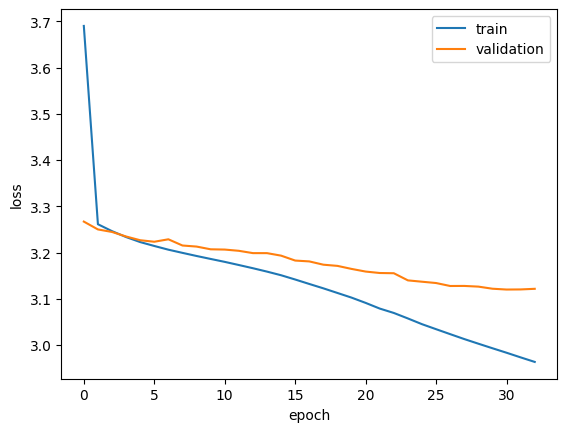

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Model Inference

In [27]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

In [28]:
encoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 200, 128)             6645632   ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  [(None, 200, 512),           788480    ['embedding[0][0]']           
 al)                          (None, 256),                                                        
                              (None, 256),                                                        
                              (None, 256),                                                  

 Feed the output and updated states back into the model iteratively to generate an entire sequence word by word.

In [29]:
decoder_state_input_h = Input(shape=(LATENT_DIM*2,))
decoder_state_input_c = Input(shape=(LATENT_DIM*2,))

# sequence length
decoder_hidden_state_input = Input(shape=(MAX_CONTENT_LEN,LATENT_DIM*2))

# Get the embeddings of the decoder sequence
decoder_embedding_2 = decoder_embedding_layer(decoder_inputs)

In [30]:
decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding_2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# #attention inference
# attn_out_inf, attn_states_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])
# decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [31]:
# dense softmax layer
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [32]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, None, 128)            2536704   ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 512)]                0         []                            
                                                                                            

In [33]:
def decode_sequence(input_sequence):
  '''
  decods the sequence predicted
  '''

  encoder_output, encoder_h, encoder_c = encoder_model.predict(input_sequence, verbose=None)

  target_sequence = np.zeros((1, 1))

  # First word of target sequence is the start word.
  target_sequence[0, 0] = target_word_index['sostok']

  stop_condition = False
  decoded_sentence = ''

  while not stop_condition:

    output_tokens, h, c = decoder_model.predict([target_sequence] + [encoder_output, encoder_h, encoder_c], verbose=None)

    # predict token
    predicted_token_index = np.argmax(output_tokens[0, -1, :])
    predicted_token = reverse_target_word_index[predicted_token_index]

    if predicted_token !='eostok':
        decoded_sentence += ' '+predicted_token

    if predicted_token  == 'eostok'  or len(decoded_sentence.split()) >= (MAX_SUMMARY_LEN-1):
        stop_condition = True

    target_sequence  = np.zeros((1,1))
    target_sequence[0, 0] = predicted_token_index

    encoder_h, encoder_c = h, c

  return decoded_sentence

In [34]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

print(reverse_target_word_index)


{1: 'sostok', 2: 'eostok', 3: 'i', 4: 'people', 5: 'it', 6: 'the', 7: 'like', 8: 'would', 9: 'get', 10: 'edit', 11: 'you', 12: 'one', 13: 'not', 14: 'got', 15: 'us', 16: 'if', 17: 'make', 18: 'time', 19: 'think', 20: 'want', 21: 'good', 22: 'even', 23: 'know', 24: 'this', 25: 'much', 26: 'shit', 27: 'way', 28: 'really', 29: 'also', 30: 'its', 31: 'could', 32: 'go', 33: 'can', 34: 'life', 35: 'bad', 36: 'still', 37: 'going', 38: 'and', 39: 'things', 40: 'better', 41: 'never', 42: 'right', 43: 'work', 44: 'fuck', 45: 'need', 46: 'years', 47: 'take', 48: 'something', 49: 'guy', 50: 'dont', 51: 'someone', 52: 'there', 53: 'back', 54: 'see', 55: 'me', 56: 'made', 57: 'friend', 58: 'world', 59: 'my', 60: 'money', 61: 'first', 62: 'lot', 63: 'them', 64: 'actually', 65: 'girl', 66: 'a', 67: 'use', 68: 'friends', 69: 'that', 70: 'everyone', 71: 'many', 72: 'thing', 73: 'probably', 74: 'without', 75: 'wrong', 76: 'say', 77: 'long', 78: 'day', 79: 'best', 80: 'in', 81: 'stop', 82: 'fucking', 83: 

In [35]:
def sequence_to_content(input_seuqnece):
    sentence = ""
    for i in input_seuqnece:
        if i != 0 :
            sentence = sentence + reverse_source_word_index[i] + " "
    return sentence

In [ ]:
sequence_to_content([10, 148, 1111, 255])

'this is an example '

In [36]:
def sequence_to_summary(input_seuqnece):
    sentence=''
    for i in input_seuqnece:
        if((i!=0 and i!= target_word_index['sostok']) and i!= target_word_index['eostok']):
            sentence=sentence + reverse_target_word_index[i]+' '
    return sentence

In [ ]:
sequence_to_summary([25, 134, 1017, 639])

'this is an example '

In [37]:
for i in range(0,5):
    print("Content:",sequence_to_content(x_train[i]))
    print("Original summary:",sequence_to_summary(y_train[i]))
    print("Predicted summary:",decode_sequence(x_train[i].reshape(1,MAX_CONTENT_LEN)))
    print("\n")


Content: i think might missed point trying make if military made gun loving americans back people against senators need guns who need fight long military side the idea armed militia fight illegitimate government based countering military part it if military backing government government stand chance then bunch old men bureaucrats 
Original summary: having armed militia government backed armed forces 
Predicted summary:  the us people want get sense


Content: this meme picture words something becomes meme numerous rehashing within community think inside joke also memes always image macros like fry things like stories ending loch ness monster asking considered meme also 
Original summary: i can not wait kids go back school 
Predicted summary:  its like people want get back


Content: i half iranian i always think want stick traditions live like times comes going flight stairs chant bar america follow strict sobriety yet love using latest either made america technology invented here enga

In [38]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

for i in range(0, 5):
  # Decode the summary and prediction
  actual_summary = sequence_to_summary(y_train[i])
  predicted_summary = decode_sequence(x_train[i].reshape(1,MAX_CONTENT_LEN))

  scores = scorer.score(predicted_summary,actual_summary)

  print(f"Iteration {i+1}")
  print("Content:",sequence_to_content(x_train[i]))
  print("Original summary:",sequence_to_summary(y_train[i]))
  print("Predicted summary:",decode_sequence(x_train[i].reshape(1,MAX_CONTENT_LEN)))

  # Print ROUGE scores
  print("ROUGE-1 F Score: ", scores['rouge1'].fmeasure)
  print("ROUGE-1 Precision: ", scores['rouge1'].precision)
  print("ROUGE-1 Recall: ", scores['rouge1'].recall)
  print("ROUGE-L F Score: ", scores['rougeL'].fmeasure)
  print("ROUGE-L Precision: ", scores['rougeL'].precision)
  print("ROUGE-L Recall: ", scores['rougeL'].recall)
  print("---------------------------------")


Iteration 1
Content: i think might missed point trying make if military made gun loving americans back people against senators need guns who need fight long military side the idea armed militia fight illegitimate government based countering military part it if military backing government government stand chance then bunch old men bureaucrats 
Original summary: having armed militia government backed armed forces 
Predicted summary:  the us people want get sense
ROUGE-1 F Score:  0.0
ROUGE-1 Precision:  0.0
ROUGE-1 Recall:  0.0
ROUGE-L F Score:  0.0
ROUGE-L Precision:  0.0
ROUGE-L Recall:  0.0
---------------------------------
Iteration 2
Content: this meme picture words something becomes meme numerous rehashing within community think inside joke also memes always image macros like fry things like stories ending loch ness monster asking considered meme also 
Original summary: i can not wait kids go back school 
Predicted summary:  its like people want get back
ROUGE-1 F Score:  0.1428571

In [39]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rougeL_scores = []

# Loop through the validation data
for i in range(0, 1000):
  if i % 100 == 0:
    print(f"Processing sample {i}")
  scores = scorer.score(sequence_to_summary(y_valid[i]), decode_sequence(x_valid[i].reshape(1, MAX_CONTENT_LEN)))
  rouge1_scores.append(scores['rouge1'][1])
  rougeL_scores.append(scores['rougeL'][1])


# Calculate average scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average Rouge-1 Score: ", average_rouge1)
print("Average Rouge-L Score: ", average_rougeL)

# # test: Print individual scores
# for i in range(len(rouge1_scores)):
#     print(f"Sample {i}: Rouge-1: {rouge1_scores[i]}, Rouge-L: {rougeL_scores[i]}")


Processing sample 0
Processing sample 100
Processing sample 200
Processing sample 300
Processing sample 400
Processing sample 500
Processing sample 600
Processing sample 700
Processing sample 800
Processing sample 900
Average Rouge-1 Score:  0.048142983635818905
Average Rouge-L Score:  0.04709789507876319


In [40]:
for i in range(1001, 2000):
  if i % 100 == 0:
    print(f"Processing sample {i}")
  scores = scorer.score(sequence_to_summary(y_valid[i]), decode_sequence(x_valid[i].reshape(1, MAX_CONTENT_LEN)))
  rouge1_scores.append(scores['rouge1'][1])
  rougeL_scores.append(scores['rougeL'][1])


# Calculate average scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average Rouge-1 Score: ", average_rouge1)
print("Average Rouge-L Score: ", average_rougeL)


Processing sample 1100
Processing sample 1200
Processing sample 1300
Processing sample 1400
Processing sample 1500
Processing sample 1600
Processing sample 1700
Processing sample 1800
Processing sample 1900
Average Rouge-1 Score:  0.0477787784791181
Average Rouge-L Score:  0.04653364030208361


In [42]:
for i in range(2001, 3000):
  if i % 100 == 0:
    print(f"Processing sample {i}")
  scores = scorer.score(sequence_to_summary(y_valid[i]), decode_sequence(x_valid[i].reshape(1, MAX_CONTENT_LEN)))
  rouge1_scores.append(scores['rouge1'][1])
  rougeL_scores.append(scores['rougeL'][1])


# Calculate average scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average Rouge-1 Score: ", average_rouge1)
print("Average Rouge-L Score: ", average_rougeL)


Processing sample 2100
Processing sample 2200
Processing sample 2300
Processing sample 2400
Processing sample 2500
Processing sample 2600
Processing sample 2700
Processing sample 2800
Processing sample 2900
Average Rouge-1 Score:  0.04808656676549531
Average Rouge-L Score:  0.04676948389248885


In [43]:
for i in range(3001, 4000):
  if i % 100 == 0:
    print(f"Processing sample {i}")
  scores = scorer.score(sequence_to_summary(y_valid[i]), decode_sequence(x_valid[i].reshape(1, MAX_CONTENT_LEN)))
  rouge1_scores.append(scores['rouge1'][1])
  rougeL_scores.append(scores['rougeL'][1])


# Calculate average scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average Rouge-1 Score: ", average_rouge1)
print("Average Rouge-L Score: ", average_rougeL)


Processing sample 3100
Processing sample 3200
Processing sample 3300
Processing sample 3400
Processing sample 3500
Processing sample 3600
Processing sample 3700
Processing sample 3800
Processing sample 3900
Average Rouge-1 Score:  0.049126994050665576
Average Rouge-L Score:  0.04773413138952833


In [44]:
for i in range(4001, 5400):
  if i % 100 == 0:
    print(f"Processing sample {i}")
  scores = scorer.score(sequence_to_summary(y_valid[i]), decode_sequence(x_valid[i].reshape(1, MAX_CONTENT_LEN)))
  rouge1_scores.append(scores['rouge1'][1])
  rougeL_scores.append(scores['rougeL'][1])


# Calculate average scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average Rouge-1 Score: ", average_rouge1)
print("Average Rouge-L Score: ", average_rougeL)

Processing sample 4100
Processing sample 4200
Processing sample 4300
Processing sample 4400
Processing sample 4500
Processing sample 4600
Processing sample 4700
Processing sample 4800
Processing sample 4900
Processing sample 5000
Processing sample 5100
Processing sample 5200
Processing sample 5300
Average Rouge-1 Score:  0.048893278909831576
Average Rouge-L Score:  0.047465026543607756
